In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)

In [4]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool= TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    query = state['query']
    results = tavily_search_tool.invoke(query)
    
    return {'context': results}

C:\Users\HP\AppData\Local\Temp\ipykernel_22596\3342434717.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool= TavilySearchResults(


In [5]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull('rlm/rag-prompt')

generate_llm = ChatOpenAI(model='gpt-4o')

def web_generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# OpenAI의 GPT-4o-mini 모델을 사용합니다
basic_llm = ChatOpenAI(model="gpt-5")

def basic_generate(state: AgentState) -> AgentState:
    query = state['query']
    basic_llm_chain = basic_llm | StrOutputParser()
    llm_response = basic_llm_chain.invoke(query)
    return{'answer': llm_response}

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store','llm','web_search'] = Field(
        description="The target for the query to answer"
    )
    
router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about KDU(Kyungdong University) specifically Global campus.
first and foremost for each query visit 'vector_store' if no context available then
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
if you think the question needs more clarification for proper routing use 'llm' to ask the user to clarify the question
"""

router_prompt = ChatPromptTemplate.from_messages([
    ('system',router_system_prompt),
    ('user','{query}')
])

router_llm = ChatOpenAI(model="gpt-5")
structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    
    query = state['query']
    router_chain = router_prompt | structured_router_llm
    
    route = router_chain.invoke({'query': query})
    
    return route.target

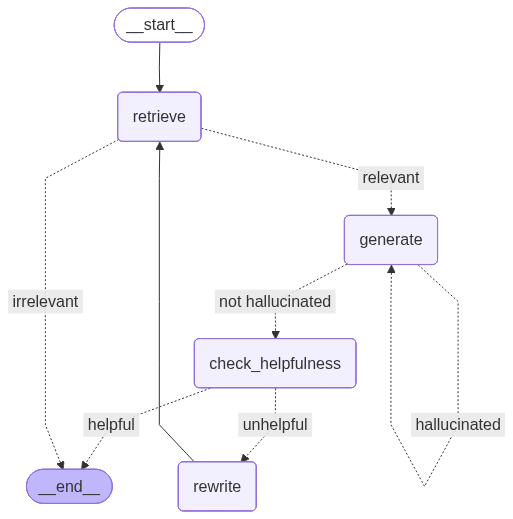

In [8]:
from self_Reflection_RAG import graph as self_reflection_subgraph

graph_builder.add_node('self_reflection_agent', self_reflection_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [9]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'vector_store': 'self_reflection_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search','web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('self_reflection_agent', END)


In [10]:
graph = graph_builder.compile()

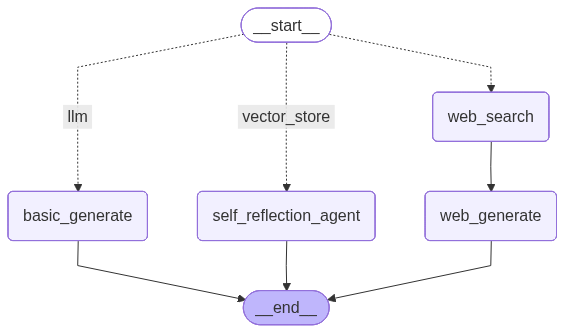

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [11]:
initial_state = {'query': 'what scholarship options are there in kdu?'}
graph.invoke(initial_state)

{'query': 'what scholarship options are there in kdu?',
 'context': [Document(id='c010d18c-2ab0-4000-8815-26b2267ca495', metadata={'doc_type': 'Admissions', 'source': 'knowledge-base-documents\\Admissions\\Scholarships and Fees _ Kyungdong University.txt'}, page_content="Undergraduate and\nAverage grade of 80%: 50%\nscholarship.\n\n\ngraduate students.\nAverage grade of 90%: 70% scholarship.\n\n\nRange: up to 100% of\ntuition fee.\nAverage grade of 95% or above: 100% scholarship.\n\nGraduate courses:\nAverage grade of 80%: 50% scholarship.\n\nAverage grade of 90% or above: 70% scholarship.\n\nKDU Global\nGranted to students who\nUndergraduate and graduate students who demonstrate exemplary contribution to KDU Global and commitment to their studies with:\nOfficial recommendations by Deans and Heads of Departments\nNot more than three hours of unexcused absence in each subject enrolled.\nBased on individual\nCitizen\nScholarship\nuphold core principles in discipline, moral values,\n\nass

In [12]:
initial_state = {'query': 'what is tuition fee for undergraduate courses at kdu?'}
graph.invoke(initial_state)


{'query': 'what is tuition fee for undergraduate courses at kdu?',
 'context': [Document(id='bc29a6e4-7528-4a9b-9139-061403b2296e', metadata={'doc_type': 'Admissions', 'source': 'knowledge-base-documents\\Admissions\\Scholarships and Fees _ Kyungdong University.txt'}, page_content='Tuition Fees and Estimated Cost of Living\nTuition Fees for International Students for 2026-2027 at KDU Global\n\n\nProgram of Study\nCourses\nTuition Fee\nNotes\nUndergraduate Degree Courses\nInternational Business Administration  (English medium)\nInternational Hotel Management (English medium)\nSmart Computing (English medium)\nArtificial Intelligence (English medium)\nKorean Business Convergence (Korean medium)\n$4,000*\nPer semester (Six months)\nThe amount indicated is without scholarships.\n\n\nProgram of Study\nCourses\nTuition Fee\nNotes\nGraduate Degree Courses\nArtificial Intelligence and Data Science\n(English medium)\nInternational Business Administration  (English medium)\nInternational Hospita

In [13]:
initial_state = {'query': 'what is capital city of mali?'}
graph.invoke(initial_state)

{'query': 'what is capital city of mali?',
 'answer': 'The capital city of Mali is Bamako.'}

In [12]:
initial_state = {'query': 'suggest me what to do in gangwon-do in winter'}
graph.invoke(initial_state)

{'query': 'suggest me what to do in gangwon-do in winter',
 'answer': 'Awesome choice—Gangwon-do is perfect in winter. Here are concise, practical ideas across interests, plus sample itineraries and tips.\n\nTop picks by interest\n- Snow sports\n  - Yongpyong: Biggest terrain, good snow, Rainbow slopes; night skiing.\n  - High1: High elevation = reliable powder; quieter; great for intermediates.\n  - Phoenix Pyeongchang: Solid terrain park; 2018 Olympic site.\n  - Vivaldi Park: Near Seoul, lively, very beginner-friendly.\n  - Alpensia: Family-friendly, smaller crowds; Ski Jump Tower observatory nearby.\n- Winter scenery and light hikes\n  - Seoraksan: Cable car to Gwongeumseong for snowy peaks; Ulsanbawi hike (crampons needed).\n  - Woljeongsa (Odaesan): Snowy fir-tree road and temple; easy, magical after fresh snow.\n  - Taebaeksan: Sunrise and snow-covered “ice trees”; microspikes essential.\n  - Daegwallyeong: Sheep Farm/Samyang Ranch for wide-open snowy fields and wind turbines.\n-

In [24]:
initial_state = {'query': 'what is application process at kdu?'}
graph.invoke(initial_state)

{'query': 'what is application process at kdu?',
 'context': [Document(id='941efe68-1f6e-4cc2-a146-0fd4a0d31bc3', metadata={'doc_type': 'Admissions', 'source': 'knowledge-base\\Admissions\\General Guidelines.txt'}, page_content='Undergraduate Degree Programs\nEnglish medium (Bachelor of Artificial Intelligence, Bachelor of International Business Administration, Bachelor of International Hotel Management, Bachelor of Smart Computing, Bachelor of Media and Film Production)\nCompletion of high school or equivalent level of education.\nNo longer than three years of gap after graduating from the most recent formal educational institution.\nMinimum of IELTS 5.5, TOEFL 530 (CBT 197, iBT 71), CEFR B2, TEPS 601 (New TEPS 327) of English proficiency.\nExcellent academic performance record.\nKorean medium (Bachelor of Korean Studies for Business)\nCompletion of high school or equivalent level of education.\nNo longer than three years of gap after graduating from the most recent formal educational

In [25]:
initial_state = {'query': 'what are the graduate and undergraduate courses at kdu?'}
graph.invoke(initial_state)

{'query': 'what are the graduate and undergraduate courses at kdu?',
 'context': [Document(id='94a71b82-1df5-427a-a0c4-0b3bec8a2ac3', metadata={'doc_type': 'Introduction', 'source': 'knowledge-base\\Introduction\\About.txt'}, page_content='Global Campus\nCompetent Professionals and Global Leaders\nKDU Global offers various undergraduate degree programs in English and Korean as well as language and vocational training courses for international students. All undergraduate curriculums incorporate five concurrent major-specialization tracks and liberal education courses aimed at enhancing language, intrapersonal and interpersonal skills of students. The ultimate mission of KDU Global is to guarantee professional and personal success of its graduates by equipping them with the competencies sought after in industries and communities of the 21st century.\n\nMetropole Campus\nSkills for Urban Industries\nUndergraduate degree programs at KDU Metropole are designed to accommodate the needs of st

In [26]:
initial_state = {'query': 'what are services at student services center in  kdu?'}
graph.invoke(initial_state)

{'query': 'what are services at student services center in  kdu?',
 'context': [Document(id='15c26d59-2c10-40a5-a06e-4fa57c4524d6', metadata={'doc_type': 'Introduction', 'source': 'knowledge-base\\Introduction\\Why KDU Global.txt'}, page_content='Comprehensive Student Counselling and Mentoring System\n\nKDU Global offers over 20 types of support services that ensure comprehensive individual mentoring and care for international students. Given the undeniable challenges international students face in a foreign country, one-on-one counseling and supervision is one of the key operational principles KDU Global upholds for the sake of success of each and every student.\n\nFree Korean Language Classes\n\nFrom their first semesters, all international students enroll in Korean language and communication classes that are fully sponsored by KDU Global. These classes significantly help the students swiftly adapt to the Korean lifestyle, local norms, traditions, and grab all the opportunities avail

In [14]:
initial_state = {'query': 'what can i eat on monday at cafeteria in kdu?'}
graph.invoke(initial_state)

{'query': 'what can i eat on monday at cafeteria in kdu?',
 'context': [Document(id='7bf5ad31-fdb9-4166-8aa1-26715ee8ee98', metadata={'doc_type': 'more', 'source': 'knowledge-base-documents\\more\\Dining Services.txt'}, page_content='LUNCH MENU AT CAFETERIA LOCATED IN SUNGRYEWON DORMITORY 1F\n\nOur menu consist of diverse Korean menu which changes from Monday to Thursday together with other menus.\n\nMonday to Friday Lunch Korean Menu(6000 KRW):\nMonday \nRice\nBean Sprout Soup\nBraised Hamburg Steak\nJapchae (stir-fried glass noodles with vegetables)\nDried Radish Salad\nNapa Cabbage Kimchi\n\n\nTuesday \nRice\nEgg Soup\nCheongyang-style Pork Bulgogi\nSweet and Sour Dumplings\nBean Sprout Salad\nNapa Cabbage Kimchi\n\n\nWednesday\nRice\nPumpkin Soybean Paste Soup\nBraised Spicy Chicken\nStir-fried Fishcake\nAcorn Jelly Salad\nNapa Cabbage Kimchi\n\nThursday\nRice\nDried Pollack Soup\nStir-fried Pork\nBraised Tofu\nSquid Side Dish (오복지)\nNapa Cabbage Kimchi\n\n\nFriday \nNo Korean menu

In [15]:
initial_state = {'query': 'what is the grading policy in kdu?'}
graph.invoke(initial_state)

{'query': 'what is the grading policy in kdu?',
 'context': [Document(id='c010d18c-2ab0-4000-8815-26b2267ca495', metadata={'doc_type': 'Admissions', 'source': 'knowledge-base-documents\\Admissions\\Scholarships and Fees _ Kyungdong University.txt'}, page_content="Undergraduate and\nAverage grade of 80%: 50%\nscholarship.\n\n\ngraduate students.\nAverage grade of 90%: 70% scholarship.\n\n\nRange: up to 100% of\ntuition fee.\nAverage grade of 95% or above: 100% scholarship.\n\nGraduate courses:\nAverage grade of 80%: 50% scholarship.\n\nAverage grade of 90% or above: 70% scholarship.\n\nKDU Global\nGranted to students who\nUndergraduate and graduate students who demonstrate exemplary contribution to KDU Global and commitment to their studies with:\nOfficial recommendations by Deans and Heads of Departments\nNot more than three hours of unexcused absence in each subject enrolled.\nBased on individual\nCitizen\nScholarship\nuphold core principles in discipline, moral values,\n\nassessments

In [16]:
initial_state = {'query': 'what are some of dorm rules in kdu?'}
graph.invoke(initial_state)

{'query': 'what are some of dorm rules in kdu?',
 'context': [Document(id='103db5b0-b649-4d6f-bf19-70310d547bf4', metadata={'doc_type': 'more', 'source': 'knowledge-base-documents\\more\\Dorm Rules.txt'}, page_content='Dormitory Rules and Policies (Kyungdong University Global Campus)\n\nThe purpose of these rules is to ensure that all residents live comfortably in the dormitory, focus on their studies, and practice discipline, etiquette, and personal growth through communal living. These rules apply to all enrolled students admitted to the dormitory.\n\n\nForced eviction can occur if residents:\n\nAccumulate 100 penalty points.\n\nCommit arson, theft, or bring in outsiders without permission.\n\nStay out overnight for more than 5 days without notice.\n\nDisobey staff or engage in violence or verbal abuse.\n\nDamage or remove dormitory property.\n\nAllow members of the opposite sex to enter or stay.\n\nAre otherwise deemed unfit for communal living.\n\nEvicted residents must leave withi

In [17]:
initial_state = {'query': 'In kdu how can i get from library to Yanghewon dormitory?'}
graph.invoke(initial_state)

{'query': 'In kdu how can i get from library to Yanghewon dormitory?',
 'context': [Document(id='58b0267c-5d37-4108-9b19-242ff696e998', metadata={'doc_type': 'Campus life', 'source': 'knowledge-base-documents\\Campus life\\School Facilities.txt'}, page_content='Student Housing\n\nSungreywon Dormitory\nInternational student-centered Sungreywon dormitory offers a cozy and academic environment for KDU students. It has 6 floors of living space with 171 rooms for 342 residents.\nEach room is equipped with Wi-fi to enjoy fast internet service for studying and assignments. The cafeteria serves a variety of Asian food. Students can enjoy facilities such as TV rooms, seminar rooms, and laundry.\n\n\nYangheynwon Dormitory\nYangheynwon is a friendly dormitory that welcomes freshmen. The newly renovated facilities are for residents’ convenience. It has 199 rooms for 398 students. Each room has its own Wi-Fi to access the internet. It also has a table tennis room, laundry, study rooms, an indoor gy

In [18]:
initial_state = {'query': 'How to join clubs in kdu?'}
graph.invoke(initial_state)

{'query': 'How to join clubs in kdu?',
 'context': [Document(id='62b51834-0bc5-4a4e-86fb-4225219498fb', metadata={'doc_type': 'Campus life', 'source': 'knowledge-base-documents\\Campus life\\Student Clubs and Labs _ Kyungdong University.txt'}, page_content='Whether you are academically inclined, culturally curious, or passionate about a particular hobby, the is always a place for you in our student club community:\n\n\nAcademics\nProgramming Club, Robotics Lab, Compass Society Club\n\nCulture and Religion\nKorean Culture Club, Christian Club\n\nSports and Hobbies\nKDU Global Cricket Club, KDU Global Football Club, KDU Global Basketball Club, Music Band\nInternational Culinary Club, Dance Club\nFitness Club\n\nCommunity and Volunteering\n   Environmental Club Tourism & Hospitality Club\n\nSign Up Now!\n\nHave questions or want to sign up to a specific club? Please reach out to the supervisors in charge now:'),
  Document(id='9bfdb5cc-5599-46f1-8b74-6dbdf2a5f02f', metadata={'doc_type': '

In [19]:
initial_state = {'query': 'what do we have in kdu timetable from october to november?'}
graph.invoke(initial_state)

{'query': 'what do we have in kdu timetable from october to november?',
 'context': [Document(id='76e7c40b-f69c-405e-86dc-1755214916f4', metadata={'doc_type': 'more', 'source': 'knowledge-base-documents\\more\\Fall 2025 Academic calender.txt'}, page_content='Fall 2025 Academic calendar\n\n\nAugust 25–29: Tuition Fee Payment Period\n\nSeptember 01: Opening of Classes\n\nSeptember 08: Opening of Classes\n\nSeptember 08: KIIP\n\nSeptember 10: Safety and Security Training Session\n\nSeptember 10: Freshmen General Orientation\n\nSeptember 10: Freshmen Departmental Orientation\n\nSeptember 12: Departmental Orientation / Consultation\n\nSeptember 22: Matriculation Ceremony\n\nSeptember 26: Tuition Fee Installment Payment\n\nSeptember 29 – October 02: Comprehensive Exam (Round 1)\n\nOctober 03–09: Chuseok Holiday\n\nOctober 20–24: Midterm Examination\n\nOctober 28–31: Comprehensive Exam (Round 2)\n\nNovember (TBA): KDU Got Talent\n\nNovember 24–28 (Tentative): Educational Trip\n\nNovember 28: 

In [20]:
initial_state = {'query': 'what are applications dates for spring 2026 kdu?'}
graph.invoke(initial_state)

{'query': '거주자가 알고 싶은 2026년 봄 KDU 지원 일정은 언제인가요?',
 'context': [Document(id='76e7c40b-f69c-405e-86dc-1755214916f4', metadata={'doc_type': 'more', 'source': 'knowledge-base-documents\\more\\Fall 2025 Academic calender.txt'}, page_content='Fall 2025 Academic calendar\n\n\nAugust 25–29: Tuition Fee Payment Period\n\nSeptember 01: Opening of Classes\n\nSeptember 08: Opening of Classes\n\nSeptember 08: KIIP\n\nSeptember 10: Safety and Security Training Session\n\nSeptember 10: Freshmen General Orientation\n\nSeptember 10: Freshmen Departmental Orientation\n\nSeptember 12: Departmental Orientation / Consultation\n\nSeptember 22: Matriculation Ceremony\n\nSeptember 26: Tuition Fee Installment Payment\n\nSeptember 29 – October 02: Comprehensive Exam (Round 1)\n\nOctober 03–09: Chuseok Holiday\n\nOctober 20–24: Midterm Examination\n\nOctober 28–31: Comprehensive Exam (Round 2)\n\nNovember (TBA): KDU Got Talent\n\nNovember 24–28 (Tentative): Educational Trip\n\nNovember 28: Smart Computing Projec

In [21]:
initial_state = {'query': 'for bsc fall 2025 seniours what class do they have on thursday?'}
graph.invoke(initial_state)

{'query': '질문: bsc fall 2025 거주자는 목요일에 어떤 수업이 있나요?',
 'context': [Document(id='01723f7f-2f2b-463d-bd01-f88ae67de3ef', metadata={'doc_type': 'more', 'source': 'knowledge-base-documents\\more\\Class time Table BSC Fall 2025.txt'}, page_content='Class Timetable (FALL 2025,(SENIOUR CLASS-BSC))\n\nMonday\n\n1st Period: Career Training\n\n2nd Period: Career Training\n\n3rd Period: Data Science\n\n4th Period: Data Science \n\nTuesday\n\n1st Period: Advanced Web Programming\n\n2nd Period: Advanced Web Programming\n\n3rd Period: Ethical Hacking\n\n4th Period: Ethical Hacking\n\nWednesday\n\n1st Period: KIIP\n\n2nd Period: KIIP\n\n3rd Period: KIIP\n\n4th Period: KIIP\n\nThursday\n\n1st Period: — (No Class)\n\n2nd Period: Data Science\n\n3rd Period: Advanced Web Programming\n\n4th Period: Ethical Hacking\n\nFriday\n\n1st Period: Career Training\n\n2nd Period: Smart Computing Project\n\n3rd Period: Smart Computing Project\n\n4th Period: Smart Computing Project'),
  Document(id='76e7c40b-f69c-405e-

In [23]:
initial_state = {'query': 'in kdu global where is passion hall?'}
graph.invoke(initial_state)

{'query': 'in kdu global where is passion hall?',
 'context': [Document(id='e0eed315-c53f-48dd-9f9d-9cc63ae11245', metadata={'doc_type': 'Campus life', 'source': 'knowledge-base-documents\\Campus life\\School Facilities.txt'}, page_content="School Facilities\n\nSeondeok Gym\nThis building brings an active and energetic spirit for the KDU community. It is a 300-seat indoor stadium with various purpose rooms such as sports clubs, individual students, and faculty members. Currently, various sports activities are held such as basketball, volleyball, badminton, cultural performance, and more.\n\nSchool Yard\nThis place is made of neat and comfortable artificial turf ground which is evergreen all year round. The turf ground is always ready for any purpose it may serve. There is a basketball ground, tennis ground, and a wide track.\n\nChunghyokwan\nChunghyokwan has lecture room for students. It consists of administrative rooms with research supporting rooms, professor's offices, smart-board l

In [14]:
initial_state = {'query': 'what is the menu for friday at kdu?'}
graph.invoke(initial_state)

{'query': 'what is the menu for friday at kdu?',
 'context': [Document(id='7bf5ad31-fdb9-4166-8aa1-26715ee8ee98', metadata={'doc_type': 'more', 'source': 'knowledge-base-documents\\more\\Dining Services.txt'}, page_content='LUNCH MENU AT CAFETERIA LOCATED IN SUNGRYEWON DORMITORY 1F\n\nOur menu consist of diverse Korean menu which changes from Monday to Thursday together with other menus.\n\nMonday to Friday Lunch Korean Menu(6000 KRW):\nMonday \nRice\nBean Sprout Soup\nBraised Hamburg Steak\nJapchae (stir-fried glass noodles with vegetables)\nDried Radish Salad\nNapa Cabbage Kimchi\n\n\nTuesday \nRice\nEgg Soup\nCheongyang-style Pork Bulgogi\nSweet and Sour Dumplings\nBean Sprout Salad\nNapa Cabbage Kimchi\n\n\nWednesday\nRice\nPumpkin Soybean Paste Soup\nBraised Spicy Chicken\nStir-fried Fishcake\nAcorn Jelly Salad\nNapa Cabbage Kimchi\n\nThursday\nRice\nDried Pollack Soup\nStir-fried Pork\nBraised Tofu\nSquid Side Dish (오복지)\nNapa Cabbage Kimchi\n\n\nFriday \nNo Korean menu\n\n\nMond

In [15]:
initial_state = {'query': 'what is the capital city of mali?'}
graph.invoke(initial_state)

{'query': 'what is the capital city of mali?', 'answer': 'Bamako.'}

initial_state = {'query': 'what is the website link of kdu global?'}
graph.invoke(initial_state)

## ADD CHAT INTERFACE

In [15]:
def star_rag_chat(user_input, history):
    """
    Gradio chat handler for STAR-RAG (LangGraph backend)
    """
    try:
        state = {'query': user_input}
        result = graph.invoke(state)
        answer = result.get('answer', 'No response generated.')
    except Exception as e:
        answer = f"⚠️ Error: {e}"

    return answer  # ✅ Only return the response string


In [ ]:
import gradio as gr

demo = gr.ChatInterface(
    fn=star_rag_chat,
    title="⭐ STAR-RAG: University Knowledge Assistant and General Purpose chatbot",
    description="Ask anything about kdu — admissions, courses, or general questions."
)

if __name__ == "__main__":
    demo.launch(share=True)
